In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [19]:
""" --- IMPORTACION LIBRERIAS --- """

import numpy as np
import pickle
import pathlib
import time
import cv2

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import torch.nn.functional as F


from pytorchlib.pytorch_models import models_interface
from pytorchlib.pytorch_library import utils_general, utils_training

import data_generator as data_lfw
import albumentations

In [20]:
from PIL import Image
import face_recognition

import pytorchlib.pytorch_data.load_data as load_data

In [21]:
model_type, model_cfg, optimizador, batch_size, flat_size, block_type, last_pool_size = "MobileNetv2", "MobileNetSmallv0", "SGD", 16, 512, "", 5
num_classes = 2
dropout, ruido, input_channels = 0.0, 0.0, 3
growth_rate, in_features = 0, 0
out_type, block_type = "relu", ""
slack_channel = "log_ai_work"

if type(model_cfg)==list or type(model_cfg)==tuple:
    model_cfg_txt = '_'.join(model_cfg)
else: model_cfg_txt = model_cfg

print("{} - {} utilizando {} - LFW - Color!)".format(model_type, str(model_cfg_txt), optimizador))

# Establecemos una semilla para la replicacion de los experimentos correctamente
seed = 0
torch.manual_seed(seed=seed)
torch.cuda.manual_seed(seed=seed)

MobileNetv2 - MobileNetSmallv0 utilizando SGD - LFW - Color!)


## Cargamos un modelo preentrenado

In [22]:
states_path = "models/CE_Simple_checkpoint_state_mobilenetsmall_color.pt"
model = models_interface.load_model(model_type, states_path=states_path, model_config=model_cfg, dropout=dropout, ruido=ruido, input_channels=input_channels, growth_rate=growth_rate, flat_size=flat_size, in_features=in_features, out_type=out_type, block_type=block_type, out_features=num_classes, last_pool_size=last_pool_size)

In [6]:
log_file = "models/CE_Simple_LOG_mobilenetsmall_color.pkl"
with open(log_file, 'rb') as f:
    model_log = pickle.load(f)

Best accuracy 98.26%


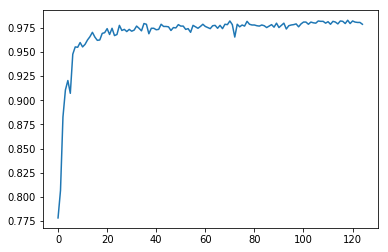

In [7]:
print("Best accuracy {:.2f}%".format(np.array(model_log["log-acc1"]).max()*100))
plt.plot(np.arange(len(model_log["log-acc1"])), model_log["log-acc1"])

### Cargamos datos de prueba

In [18]:
transforms_test = [albumentations.CenterCrop(80,80)]
test_dataset = data_lfw.NPDatasetLFW('/home/maparla/DeepLearning/PytorchDatasets/nplfwdeepfunneled/', transforms=transforms_test, exclude_fold=[1,2,3,4])
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=5, shuffle=True)

In [19]:
model.eval()
with torch.no_grad():
    for inx, (data) in enumerate(test_loader):
        preds = model(data[0].cuda())
        break
samples_np = data[0].data.cpu().numpy().transpose(0,2,3,1)
targets_np = data[1].data.cpu().numpy()

In [10]:
preds_classes = torch.argmax(preds, dim=1)

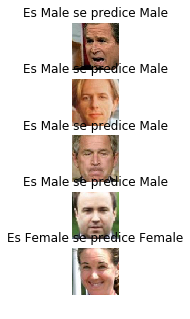

In [11]:
fig=plt.figure(figsize=(1, 5))
columns = 1
rows = 5
img_idx = 0
for i in range(1, columns*rows +1):
    img = samples_np[img_idx].astype(np.uint8)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Es " + data_lfw.CAT2CLASS[targets_np[img_idx][0]] + " se predice " + data_lfw.CAT2CLASS[preds_classes[img_idx].item()])
    img_idx+=1
plt.show()

## Probando imagen desconocida

https://github.com/ageitgey/face_recognition

In [23]:
softmax = nn.Softmax()

In [24]:
transforms_sample = albumentations.Resize(80,80)

### Caso Mujer

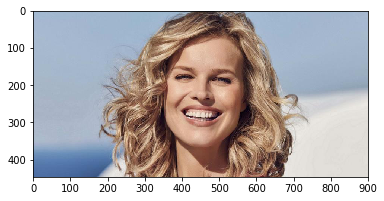

In [16]:
image_female = face_recognition.load_image_file("imagen_mujer.jpg")
plt.imshow(image_female)

In [17]:
face_locations = face_recognition.face_locations(image_female)
print("Se han detectado {} caras".format(len(face_locations)))
for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = image_female[top:bottom, left:right]
    pil_image = Image.fromarray(face_image)
    pil_image.show()

Se han detectado 1 caras
A face is located at pixel location Top: 118, Left: 340, Bottom: 341, Right: 563


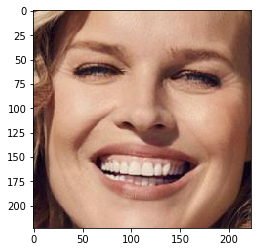

In [18]:
face_female_cropped = image_female[top:bottom, left:right]
plt.imshow(face_female_cropped)

#### Prediccion del rostro

In [19]:
face_female_cropped_transformed = load_data.apply_img_albumentation(transforms_sample, face_female_cropped)
sample_female = torch.from_numpy(face_female_cropped_transformed.transpose(2,0,1))
print("Shape de la cara {} y shape despues de la transformacion {}".format(face_female_cropped.shape, sample_female.shape))

Shape de la cara (223, 223, 3) y shape despues de la transformacion torch.Size([3, 80, 80])


In [20]:
sample_female = sample_female.unsqueeze(0).type('torch.FloatTensor')

In [21]:
prediction = model(sample_female.cuda())
preds_classes = torch.argmax(prediction, dim=1)
confianza = softmax(prediction)

In [22]:
print("Es mujer y se predice {} con confianza del {:.2f}%".format(data_lfw.CAT2CLASS[preds_classes[0].item()], confianza[0][preds_classes[0].item()].item()*100))

Es mujer y se predice Female con confianza del 100.00%


### Caso hombre

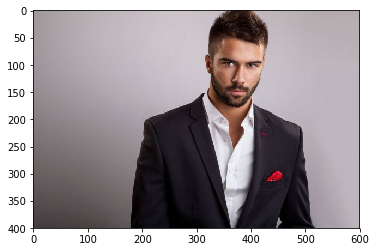

In [117]:
image_male = face_recognition.load_image_file("imagen_hombre.jpg")
plt.imshow(image_male)

In [24]:
face_locations = face_recognition.face_locations(image_male)
print("Se han detectado {} caras".format(len(face_locations)))
for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = image_male[top:bottom, left:right]
    pil_image = Image.fromarray(face_image)
    pil_image.show()

Se han detectado 1 caras
A face is located at pixel location Top: 76, Left: 335, Bottom: 166, Right: 424


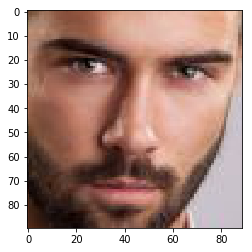

In [25]:
face_male_cropped = image_male[top:bottom, left:right]
plt.imshow(face_male_cropped)

#### Prediccion del rostro

In [26]:
face_male_cropped_transformed = load_data.apply_img_albumentation(transforms_sample, face_male_cropped)
sample_male = torch.from_numpy(face_male_cropped_transformed.transpose(2,0,1))
print("Shape de la cara {} y shape despues de la transformacion {}".format(face_male_cropped.shape, sample_male.shape))

Shape de la cara (90, 89, 3) y shape despues de la transformacion torch.Size([3, 80, 80])


In [27]:
sample_male = sample_male.unsqueeze(0).type('torch.FloatTensor')

In [28]:
prediction = model(sample_male.cuda())
preds_classes = torch.argmax(prediction, dim=1)
confianza = softmax(prediction)

In [29]:
print("Es hombre y se predice {} con confianza del {:.2f}%".format(data_lfw.CAT2CLASS[preds_classes[0].item()], confianza[0][preds_classes[0].item()].item()*100))

Es hombre y se predice Male con confianza del 100.00%


### Dibujando rectangulo

In [25]:
BLUE = (127,255,255)
PINK = (255,105,180)

def draw_border(img, left, top, right, bottom, color, thickness, r, d):
    # https://stackoverflow.com/questions/46036477/drawing-fancy-rectangle-around-face
    x1,y1 = left,top
    x2,y2 = right,bottom

    # Top left
    cv2.line(img, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
    cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)

    # Top right
    cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)

    # Bottom left
    cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
    cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)

    # Bottom right
    cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)

# ============================================================================

In [26]:
def draw_text(img, left, top, text, color, thickness, font_scale):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (left, top)

    return cv2.putText(img,text, 
        bottomLeftCornerOfText, 
        font, font_scale,
        color, thickness)

In [126]:
draw_border(image_male, left, top, right, bottom, BLUE, 2, 10, 20)

In [128]:
image_male = draw_text(image_male, left, top-5, "Male", BLUE, 2, 0.9)

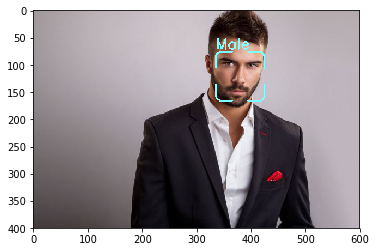

In [129]:
plt.imshow(image_male)

### Posibles multiples rostros, prediccion y dibujo

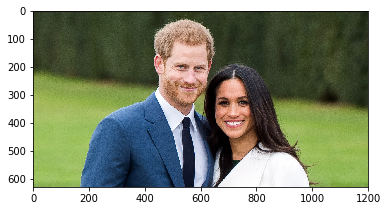

In [27]:
image_multiple = face_recognition.load_image_file("imagen_multiple.jpg")
plt.imshow(image_multiple)

In [28]:
model.eval()

MobileNetV2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
     

In [29]:
%%time
face_locations = face_recognition.face_locations(image_multiple)
print("Se han detectado {} caras".format(len(face_locations)))
for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    
    # Tomamos el rostro y lo transformamos a formato torch
    face_cropped = image_multiple[top:bottom, left:right]
    face_cropped_transformed = load_data.apply_img_albumentation(transforms_sample, face_cropped)
    sample = torch.from_numpy(face_cropped_transformed.transpose(2,0,1))
    sample = sample.unsqueeze(0).type('torch.FloatTensor')
    
    # Hacemos la prediccion del rostro
    with torch.no_grad():
        prediction = model(sample.cuda())
    preds_classes = torch.argmax(prediction, dim=1)
    confianza = softmax(prediction)

    # Sacamos la informacion de la prediccion
    genero = data_lfw.CAT2CLASS[preds_classes[0].item()]
    confianza = confianza[0][preds_classes[0].item()].item()*100
    
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {} - {} con confianza {:.2f}".format(top, left, bottom, right, genero, confianza))
    
    if genero.lower()=="female":
        draw_border(image_multiple, left, top, right, bottom, PINK, 4, 10, 20)
        image_multiple = draw_text(image_multiple, left, top-15, "Female", PINK, 4, 1.5)
    else:
        draw_border(image_multiple, left, top, right, bottom, BLUE, 4, 10, 20)
        image_multiple = draw_text(image_multiple, left, top-15, "Male", BLUE, 4, 1.5)

    # You can access the actual face itself like this:
    #face_image = image_multiple[top:bottom, left:right]
    #pil_image = Image.fromarray(face_image)
    #pil_image.show()

Se han detectado 2 caras
A face is located at pixel location Top: 288, Left: 631, Bottom: 442, Right: 786 - Female con confianza 100.00
A face is located at pixel location Top: 139, Left: 469, Bottom: 325, Right: 655 - Male con confianza 100.00
CPU times: user 434 ms, sys: 11.2 ms, total: 445 ms
Wall time: 443 ms


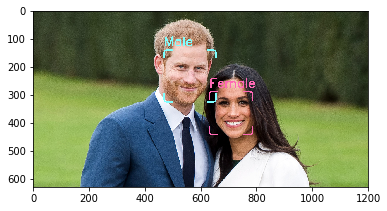

In [30]:
plt.imshow(image_multiple)